In [1]:
import torch
import skimage
import matplotlib.pyplot as plt
import numpy as np
%cd ../

/home/paperspace/mlproj2_new/ActMax-Optimizer-Dev


In [2]:
from transformers.vit_model import VisionTransformer
from transformers.tf_exp import TransformerEvolution
from core.insilico_exps import resize_and_pad_tsr

In [3]:
modelpath = './transformers/model.pt'

In [4]:
model_dic = torch.load(modelpath)

In [5]:
model_kwargs={'embed_dim': 256,
'hidden_dim': 512,
'num_heads': 8,
'num_layers': 6,
'patch_size': 4,
'num_channels': 3,
'num_patches': 64,
'num_classes': 10,
'dropout': 0.2}

In [6]:
vit = VisionTransformer(**model_kwargs)

In [7]:
vit.load_state_dict(model_dic)

<All keys matched successfully>

In [8]:
from transformers.tf_exp import TransformerScorer

In [9]:
model = TransformerScorer('own_vit', imgpix=32)

In [11]:
model_unit = ("own_vit", ".mlp_head.Linear1", 0)

In [12]:
exp = TransformerEvolution(model_unit, imgsize=(32, 32))

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050


In [13]:
exp.run()

synth img scores: mean -3.488 +- std 0.000
step 0  time: total 0.64s | GAN visualize 0.57s   Transformers score 0.01s   optimizer step 0.06s
sigma: 2.90
synth img scores: mean -3.395 +- std 3.561
step 1  time: total 0.16s | GAN visualize 0.08s   Transformers score 0.03s   optimizer step 0.04s
sigma: 2.83
synth img scores: mean -2.267 +- std 3.554
step 2  time: total 0.21s | GAN visualize 0.09s   Transformers score 0.01s   optimizer step 0.10s
sigma: 2.76
synth img scores: mean -1.108 +- std 3.641
step 3  time: total 0.13s | GAN visualize 0.06s   Transformers score 0.03s   optimizer step 0.04s
sigma: 2.71
synth img scores: mean -0.217 +- std 3.842
step 4  time: total 0.12s | GAN visualize 0.06s   Transformers score 0.01s   optimizer step 0.04s
sigma: 2.66
synth img scores: mean 2.734 +- std 3.052
step 5  time: total 0.12s | GAN visualize 0.06s   Transformers score 0.01s   optimizer step 0.05s
sigma: 2.62
synth img scores: mean 3.462 +- std 3.428
step 6  time: total 0.11s | GAN visualize

In [14]:
idx = np.argmax(exp.scores_all)
select_code = exp.codes_all[idx : idx + 1, :]
score_select = exp.scores_all[idx]
img_select = exp.render_tsr(select_code)
resize_select = resize_and_pad_tsr(img_select, exp.imgsize, exp.corner, canvas_size=(32, 32))
resize_select = resize_select.cpu().squeeze().permute((1, 2, 0)).numpy()

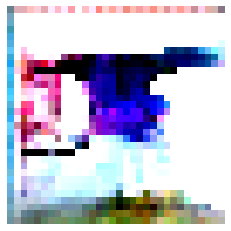

In [15]:
plt.imshow(resize_select)
plt.axis('off')
plt.show()

Test super activation

In [26]:
# Load the CIFAR10 dataset
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [31]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = CIFAR10(root="./data", train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=4)

Files already downloaded and verified


In [43]:
from tqdm import tqdm

In [44]:
# Get a certain class of images
class_idx = 0
airplanes = []
for (x, y) in tqdm(train_loader):
    if y == class_idx:
        airplanes.append(x)

100%|██████████| 50000/50000 [01:33<00:00, 534.81it/s]


In [48]:
airplanes_tsr = torch.cat(airplanes)

In [50]:
# Calculate the scores of the images
from transformers.tf_exp import TransformerScorer
model = TransformerScorer('own_vit', imgpix=32)
model.select_unit(model_unit)

In [52]:
scores = model.score_tsr(airplanes_tsr)

In [54]:
resize_select.shape

(32, 32, 3)

In [55]:
# Get the score of the generated image
syn_tsr = torch.Tensor(resize_select).permute((2, 0, 1)).unsqueeze(0)
syn_score = model.score_tsr(syn_tsr)
syn_score

array([21.85589981])

In [56]:
# Save the scores of the natural images into a csv file
import pandas as pd
df = pd.DataFrame(scores, columns=['nature_score'])
df.to_csv('./results/own_vit/airplane_own_vit_nature.csv')